# Model Evaluation of a Logistic Regression

In this workbook we will use the Wisconsin Breast Cancer dataset to run a Logistic Regression model and then to evaluate its fit with a number of scoring metrics. Let's kick off by importing the required libraries.

In [1]:
from __future__ import division
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc

The dataframe requires a little construction work in order to really get started.

In [2]:
attributes = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness',
              'concavity', 'concave_points', 'symmetry', 'fractal_dimension']

dimensions = ['mean', 'se', 'worst']

attribute_names = ['{}-{}'.format(x, y) for x in attributes for y in dimensions]

In [3]:
column_names = ['id', 'diagnosis'] + attribute_names
df = pd.read_csv('data/breast_cancer.csv', header = None, names = column_names)
df.head()

,id,diagnosis,radius-mean,radius-se,radius-worst,texture-mean,texture-se,texture-worst,perimeter-mean,perimeter-se,...,concavity-worst,concave_points-mean,concave_points-se,concave_points-worst,symmetry-mean,symmetry-se,symmetry-worst,fractal_dimension-mean,fractal_dimension-se,fractal_dimension-worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


To make some steps more straightforward we will use the mapping function to change the diagnosis 'Malignant' to 1 and 'Benign' to 0.

In [4]:
mapping = {"B":0, "M":1}
df["diagnosis_2"] = df["diagnosis"].map(mapping)

Create the feature matrix and target vector.

In [5]:
X = df[attribute_names]
y = df['diagnosis_2']
y.value_counts()

0    357
1    212
Name: diagnosis_2, dtype: int64

Split the data into a train / test split.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 10)

Then run the Logistic Regression - instantiate, fit and get the predictions.

In [7]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

With some supervised machine learning techniques various class values are predicted, but there are no underlying probability outputs that can be utilised. Logistic Regression, however, is a classification algorithm that does have this capability - we can get the probabilities from the *predict_proba* function. Why is this useful? Well, for a binary problem probabilities less than 0.5 are assigned a class of 0 and those greater than or equal to 0.5 are given a class of 1. That is intuitive of course but we could in theory assign a cut-off point of 0.4 or 0.45 instead of 0.5. This isn't always used but it does give the user the opportunity to define the classification threshold when using Logistic Regression.

In [8]:
y_prob = model.predict_proba(X_test)

Ok, great, we have run the Logistic Regression model. Time to perform some model evaluation.

### Confusion Matrix

The Confusion Matrix shows us a breakdown of the various predictions and results.

|Type|Description|
|---|---|---|
| True Positive TP| A positive prediction was followed by a positive result|
| False Positive FP| A positive prediction was followed by a negative result|
| True Negative TN| A negative prediction was followed by a negative result|
| False Negative FN| A negative prediction was followed by a positive result|

In this particular case we are looking to see how predictions of cancer turn out. If we predict that a tumour is benign, we hope this stays negative (true negative) as a false negative would be devastating for the patient. However, if we predicted a positive (tumour is malignant) then if this transpired to actually be negative (that is, a false positive) then this is good news for the patient.

In the confusion matrix below we have a total sum of 188, this is the test set generated from the train test split earlier. Of the tumours predicted to be benign, 117 out of 120 turned out to be so. And of those predicted to be malignant, 61 out of 68 turned out that way.

In [9]:
cm = confusion_matrix(y_test, y_pred)
con_mat = pd.DataFrame(cm, index = ['is_benign', 'is_malignant'], columns = ['predicted_benign', 'predicted_malignant'])
con_mat

,predicted_benign,predicted_malignant
is_benign,117,7
is_malignant,3,61


Let's get the four values into memory - this will come in handy for later use.

In [10]:
TP = con_mat.loc['is_malignant', 'predicted_malignant']
TN = con_mat.loc['is_benign', 'predicted_benign']
FP = con_mat.loc['is_benign', 'predicted_malignant']
FN = con_mat.loc['is_malignant', 'predicted_benign']

Now we move on to scoring metrics.

### Accuracy

The accuracy score is defined as

$$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$$

In [11]:
print 'Accuracy score in skLearn', accuracy_score(y_test, y_pred).round(4)

Accuracy score in skLearn 0.9468


In [12]:
print 'Accuracy score', round((TP+TN)/(TP+TN+FP+FN),4)

Accuracy score 0.9468


It shows the proportion of all the true values relative to the sum of all the values. We see here that the model correctly predicts (whether that be positive or negative) 94.7% of the time. 

### Precision

Now we look at Precision, of which there are two types.

$$Precision_{Positive} = \frac{TP}{TP+FP}$$

$$Precision_{Negative} = \frac{TN}{TN+FN}$$

In [13]:
# SciKit Learn will give us a weighting of the positive and negative scores
print 'Precision score in skLearn', precision_score(y_test, y_pred, average = 'macro').round(4)

Precision score in skLearn 0.936


In [14]:
precision_pos = TP/(TP+FP)
print 'Precision Positive', precision_pos.round(4)

Precision Positive 0.8971


In [15]:
precision_neg = TN/(TN+FN)
print 'Precision Negative', precision_neg.round(4)

Precision Negative 0.975


With $Precision_{Positive}$ we evaluate the proportion of true positives out of all the predicted positives. Likewise for $Precision_{Negative}$ we evaluate the proportion of the true negatives relative to all the predicted negatives. We see in the above example that of all the positive predictions, nearly 90% turned out to be positive. Over 97% was obtained for the negative precision. This is quite encouraging. Of the positive predictions there is still a 10.3% chance the diagnosis is incorrect.

### Recall

Like Precision, recall has a Positive and Negative version.

$$Recall_{Positive} = \frac{TP}{TP+FN}$$

$$Recall_{Negative} = \frac{TN}{TN+FP}$$

In [16]:
print 'Recall score in skLearn', recall_score(y_test, y_pred, average = 'macro').round(4)

Recall score in skLearn 0.9483


In [17]:
recall_pos = TP/(TP+FN)
print 'Recall Positive', recall_pos.round(4)
print 'This is also known as Sensitivity'

Recall Positive 0.9531
This is also known as Sensitivity


In [18]:
recall_neg = TN/(TN+FP)
print 'Recall Negative', recall_neg.round(4)
print 'This is also known as Specificity'

Recall Negative 0.9435
This is also known as Specificity


In $Recall_{Positive}$ we say: of all the results that turned out to be positive, how many had been predicted to do so? And with $Recall_{Negative}$ we say: of all the results that turned out to be negative, how many had been predicted to do so? Looking at the results above, the negative recall is higher than the positive recall. So for the results that turned out to be positive (the tumour is malignant) around 95% had been predicted. Whereas with the negative recall, about 94% of actual negatives had been predicted.

### F1 Score

The F1 Score gives an average of Precision and Recall.

$$F1 = \frac{2 \times Precision \times Recall}{Precision + Recall}$$

In [19]:
print 'F1 score in skLearn', f1_score(y_test, y_pred, average = 'macro').round(3)

F1 score in skLearn 0.942


In [20]:
f1_pos = 2*precision_pos*recall_pos/(precision_pos+recall_pos)
print 'F1 Score Positive', f1_pos.round(4)

F1 Score Positive 0.9242


In [21]:
f1_neg = 2*precision_neg*recall_neg/(precision_neg+recall_neg)
print 'F1 Score Negative', f1_neg.round(4)

F1 Score Negative 0.959


### Classification Report

Above I ran the reader through the calculations manually for completeness. With skLearn however the Precision, Recall and F1 Scores can be condensed into a single report.

In [22]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.97      0.94      0.96       124
          1       0.90      0.95      0.92        64

avg / total       0.95      0.95      0.95       188



### Receiver Operating Characteristic (ROC) Curve

Here we plot the ROC curve, with a brief discussion of what it is afterwards.

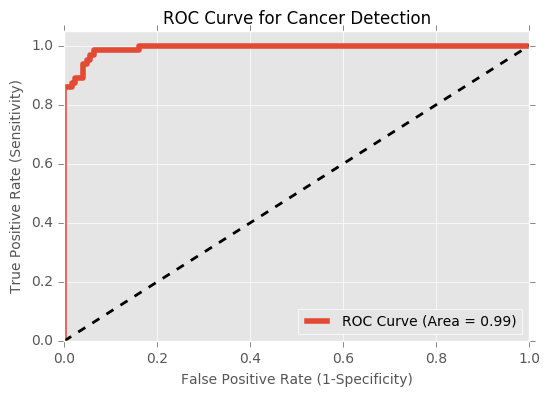

In [23]:
y_decision = model.decision_function(X_test)
FPR, TPR, THR = roc_curve(y_test, y_decision)
roc_auc = auc(FPR, TPR)
plt.plot(FPR, TPR, label = 'ROC Curve (Area = %0.2f)' % roc_auc, linewidth = 4)
plt.plot([0, 1], [0, 1], 'k--', linewidth = 2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-Specificity)', fontsize = 10)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 10)
plt.title('ROC Curve for Cancer Detection', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 10)
plt.show()

The ROC curve compares the True Positive Rate (TPR) against the False Positive Rate (FPR). The TPR is known as the Sensitivity, or also the Recall Positive which we know from before is TP/(TP+FN). That is, of all the results that were actually positive, what proportion had been predicted to be so? The FPR is defined as 1-Specificity, with Specificity also being the Recall Negative, which we know is TN/(TN+FP). Thus the ROC curve is unaffected by the distribution of class labels since it is only comparing the correct versus incorrect label assignments. The curve is generated by varying a threshold across a range of values and then seeing how the TPR and FPR compare.

While terms such as True Positive Rate and Sensitivity may not be that intuitive, the nature of the graph is quite easy to interpret. We seek to maximise the Area Under the Curve (AUC), and the closer this value is to one the better the classifier is. We look to obtain a line (the solid line above) that will be close to the top left corner of the chart - this will help maximise the AUC. Random guessing the classes would lead to a profile depicted by the dotted line which gives an AUC of 0.5.